In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [34]:
transition_probabilities = [  # shape=[s, a, s']
                                [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
                                [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
                                [None, [0.8, 0.1, 0.1], None]
                            ]
rewards = [  # shape=[s, a, s']
            [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
            [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
            [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
        ]
 # shape = [s]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [35]:
Q_values = np.full((3,3), -np.inf)
for state, action in enumerate(possible_actions):
    Q_values[state][action] = 0

In [36]:
def step(state,action):
    """
    Ye wala function will define a individual step the agent is gonna take by taking the current state and action
    It will be a random action though and also
    
    NEXT_STATE CHOOSEN HERE WILL BE RANDOM.

    Args:
        state : the state agent is currently in
        action : current action

    Returns:
        next_state :  randomly_choosen
        reward : reward we get after choosing that particular action or state
    """
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward


def exploration_policy(state):
    return np.random.choice(possible_actions[state])

alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90   # discount factor
state = 0      #initial state

# Q-learning algorithm

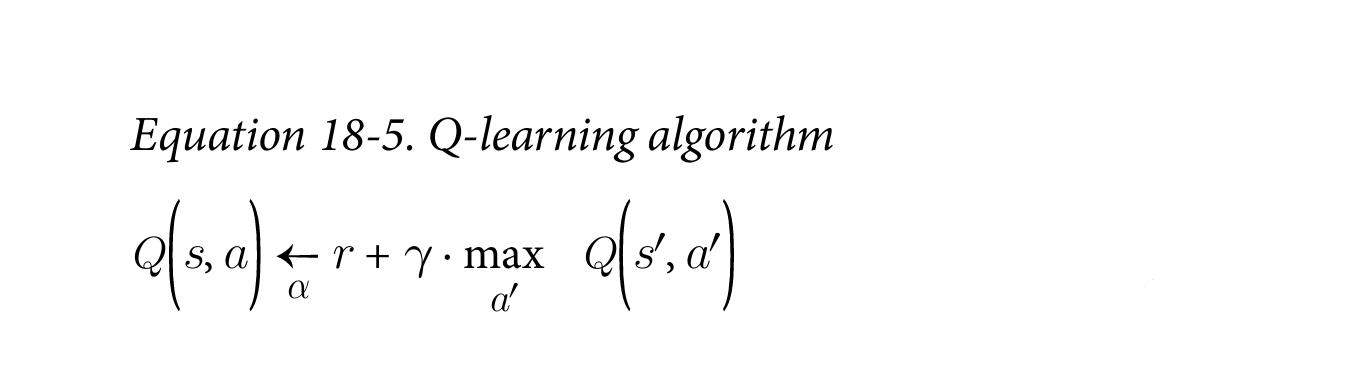

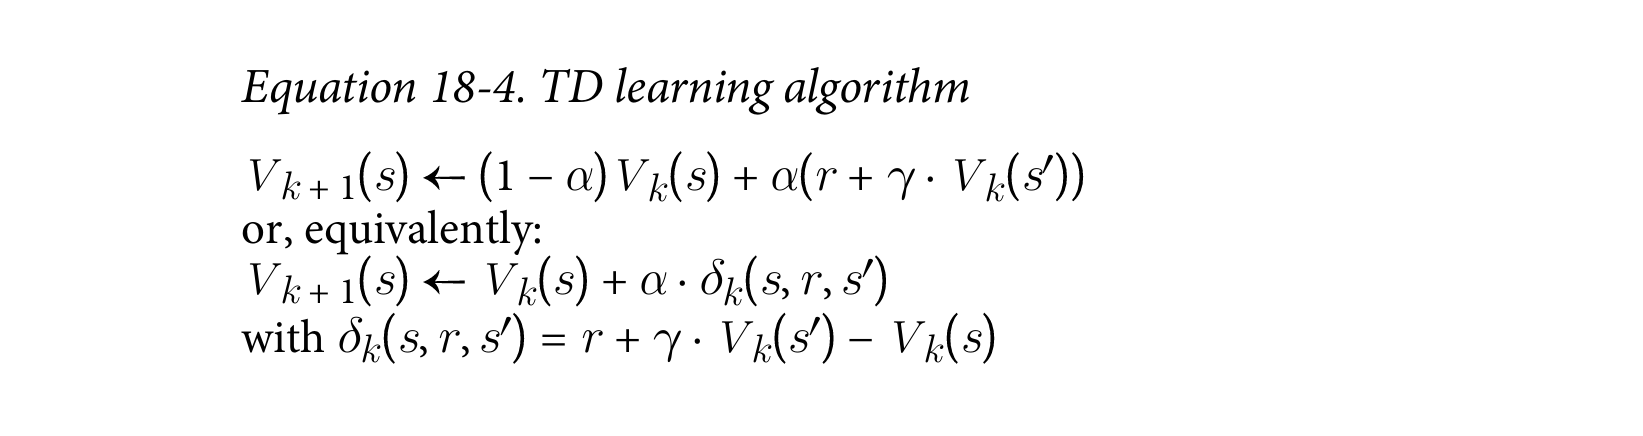

In [ ]:
for iteration in range(100000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()  # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay) # learning rate
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value) #TDL ka formula
    state = next_state
    

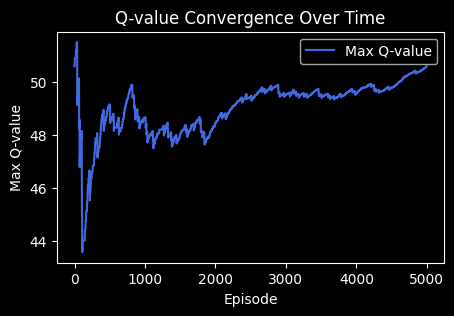

In [32]:
episodes = 5000

# Tracking Q-values over time to plot in matplotlib
q_evolution = []

for iteration in range(episodes):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] += alpha * (reward + gamma * next_value - Q_values[state, action])
    state = next_state
    
    # Store max Q-value for plotting
    q_evolution.append(Q_values.max())

# Plot Q-value evolution
plt.figure(figsize=(5, 3))
plt.plot(q_evolution, label="Max Q-value", color="royalblue")
plt.xlabel("Episode")
plt.ylabel("Max Q-value")
plt.title("Q-value Convergence Over Time")
plt.legend()
plt.show()


### We were using random policy to estimate Q-values which can be good for smaller environemnts which has fewer states and actions but It might get complex with big **enviroenmtns**

# Let's try :
### DQN as a function approximator which has lesser and fewer parameters

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

In [19]:
#creating the gym env
env = gym.make('CartPole-v1', render_mode='rgb_array')
obs, info = env.reset(seed=42)

In [20]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4,32),
            nn.ELU(),
            nn.Linear(32,32),
            nn.ELU(),
            nn.Linear(32,2)
        )
    def forward(self, x):
        return self.model(x)

model = SimpleModel()
# list(model.parameters())
shapes = [param.shape for param in model.parameters()]
print(shapes)

[torch.Size([32, 4]), torch.Size([32]), torch.Size([32, 32]), torch.Size([32]), torch.Size([2, 32]), torch.Size([2])]


This corresponds to:

        First layer weights
        First layer biases
        Second layer weights
        Second layer biases
        Third layer weights
        Third layer biases

## Also we will:
### **pick the action with the largest predictedQ-value.**

In [13]:
input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

def epsilon_greedy_policy(state, epsilon=0):
    if(np.random.rand()<epsilon):
        return np.random.randint(model.model[-1].out_features) # (model.model[-1].out_features) = 2 
    else:
        Q_val = model(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
        # return Q_val.argmax(dim=1).item()
        return Q_val
state = np.array([0.1, 0.2, 0.3, 0.8])  # Example state
action = epsilon_greedy_policy(state, epsilon=0.1)
print(action)


tensor([[ 0.1371, -0.2079]], grad_fn=<AddmmBackward0>)


In [15]:
from collections import deque
replay_buffer = deque(maxlen=2000)

#Each expereince consists of -> [s, a, r, s', done, truncated]

def sample_experiences(batch_size):
    """
    It will just sample expereince from replay buffer

    Args:
        batch_size (int): self_explanatory

    Returns:
        Here 
            1. We could directly return BATCH which would have following shape (batch_size, 6) for example:
            
                [
                    ([1, 2, 3, 4], 0, 1.0, [5, 6, 7, 8], False, False),    # Experience 1
                    ([17, 18, 19, 20], 0, -1.0, [21, 22, 23, 24], False, True), # Experience 2
                    ([33, 34, 35, 36], 0, 0.0, [37, 38, 39, 40], True, True)    # Experience 3
                ]
            
            2. We are here returning all s together, then all a together then all rewards and so on, eg:
            
                states      : [[1, 2, 3, 4], [17, 18, 19, 20], [33, 34, 35, 36]]
                actions	    : [0, 0, 0]
                rewards	    : [1.0, -1.0, 0.0]
                next_states	: [[5, 6, 7, 8], [21, 22, 23, 24], [37, 38, 39, 40]]
                dones       : [False, False, True]
                truncated   : [False, True, True]
                
    """
    
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [np.array([experience[field_index] for experience in batch]) for field_index in range(6)]

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    #taking action in a particular environemnt
    next_state, reward, done, truncated, info = env.step(action=action)
    #entering elements in deque
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info  

In [ ]:
"""_summary_
The purpose of training_step is to:
    Sample a batch of experiences from the replay_buffer.
    Calculate the target Q-values using the Bellman equation.
    Compute the loss between the predicted and target Q-values.
    Update the neural network weights using backpropagation.
    
"""

""`
# Understanding n_outputs and Masking in Deep Q-Learning

## 1. Number of Actions (`n_outputs`)
`n_outputs` defines the number of possible actions for the agent at each state.

For example:
```python
n_outputs = 3  # Three possible actions

# Model's predicted Q-values for one state
Q_values = torch.tensor([1.5, 2.0, -0.5])

# Choosing the action with the highest Q-value
best_action = torch.argmax(Q_values).item()
print("Best action:", best_action)  # Output: 1 (Action with max Q-value)
```

---

## 2. Masking for Q-value Extraction
When calculating the loss, we only want the Q-value for the **action actually taken** during the experience.

### Example Setup
```python
import torch
import torch.nn.functional as F

# Example Q-values predicted by the model
all_Q_values = torch.tensor([
    [1.0, 2.0, 0.5],  # Q-values for state 1
    [0.4, 0.8, -0.3]  # Q-values for state 2
])

# Actions taken (corresponding to the Q-values we want)
actions = torch.tensor([1, 0])
```

---

### Step 1: Create One-Hot Encoded Mask
```python
mask = F.one_hot(actions, num_classes=3)
print("Mask:\n", mask)
```
**Output:**
```
Mask:
 tensor([
    [0, 1, 0],  # Action 1 selected in state 1
    [1, 0, 0]   # Action 0 selected in state 2
])
```

---

### Step 2: Apply the Mask
```python
selected_Q_values = all_Q_values * mask
print("Selected Q-values (with mask applied):\n", selected_Q_values)
```
**Output:**
```
Selected Q-values (with mask applied):
 tensor([
    [0.0, 2.0, 0.0],
    [0.4, 0.0, 0.0]
])
```

---

### Step 3: Extract the Relevant Q-values
```python
Q_values = torch.sum(selected_Q_values, dim=1, keepdim=True)
print("Final extracted Q-values:\n", Q_values)
```
**Output:**
```
Final extracted Q-values:
 tensor([
    [2.0],
    [0.4]
])
```

---

## 3. Why Masking is Important
- The model predicts Q-values for **all actions**.
- Masking zeros out the Q-values for the actions **not taken**.
- The remaining non-zero values represent the Q-value for the **action that was actually taken**.

This ensures the model updates only the Q-values relevant to the agent's past decisions.
""`


In [ ]:
batch_size = 32
discount_factor = 0.95
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)
    truncateds = torch.FloatTensor(truncateds)
    
    with torch.no_grad():
        #******************* Vaiii this is not trainable-> Just predicting ********************
        next_Q_values = model(next_states)
        
        max_next_Q_values, _ = next_Q_values.max(dim=1)
        
        # Ensure dones and truncateds are boolean tensors
        if not dones.dtype == torch.bool:
            dones = dones.bool()
        if not truncateds.dtype == torch.bool:
            truncateds = truncateds.bool()
            
        # Now perform the logical OR and convert to float
        terminal = dones | truncateds
        runs = 1.0 - terminal.float()
        
        # Q_target = r + γ • (1−terminal) • maxQ(s′,a′)
        target_Q_values = rewards + runs * discount_factor * max_next_Q_values
        target_Q_values = target_Q_values.unsqueeze(1)
    
    mask = F.one_hot(actions, num_classes=n_outputs)
    
    # This one is trainable here
    all_Q_values = model(states)
    Q_values = torch.sum(all_Q_values * mask, dim=1, keepdims=True)
    
    loss = loss_fn(Q_values, target_Q_values)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# def training_step(batch_size):
#     experiences = sample_experiences(batch_size)
#     states, actions, rewards, next_states, dones, truncateds = experiences

#     states = torch.FloatTensor(states)
#     actions = torch.LongTensor(actions)
#     rewards = torch.FloatTensor(rewards)
#     next_states = torch.FloatTensor(next_states)
#     dones = torch.FloatTensor(dones)
#     truncateds = torch.FloatTensor(truncateds)

#     with torch.no_grad():
#         next_Q_values = model(torch.tensor(next_states))
#         max_next_Q_values, _ = next_Q_values.max(dim=1)
#         runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
#         target_Q_values = rewards + runs * discount_factor * max_next_Q_values
#         target_Q_values = target_Q_values.unsqueeze(1)

#     mask = F.one_hot(actions, num_classes=n_outputs)
#     all_Q_values = model(states)
#     Q_values = torch.sum(all_Q_values * mask, dim=1, keepdims=True)

#     loss = loss_fn(Q_values, target_Q_values)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

In [457]:
for episode in range(600):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break
    if episode > 50:
        training_step(batch_size)

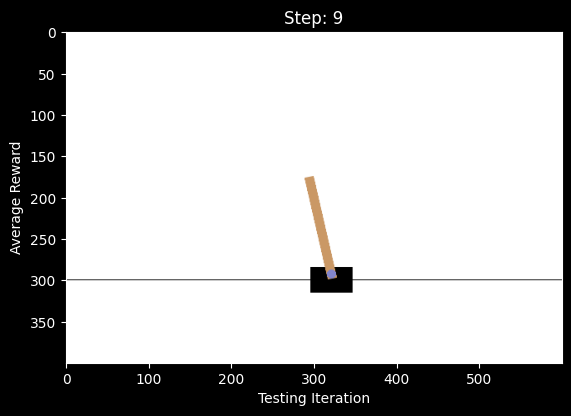

In [458]:
import matplotlib.pyplot as plt
from IPython import display

obs, info = env.reset()
img = plt.imshow(env.render())

for step in range(200+1):
    display.display(plt.gcf()) # to shows the updated plot.
    display.clear_output(wait=True) #this one clears the previous frame to create a smooth animation.
    action = epsilon_greedy_policy(state, epsilon)
    obs, reward, done, truncated, info = env.step(action)
    img.set_data(env.render())
    plt.xlabel('Testing Iteration')
    plt.ylabel('Average Reward')
    plt.title(f"Step: {step}")
    # plt.axis('off')
    if done or truncated:
        break